In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
data = pd.read_csv("compare.csv", sep = ",")
movella = pd.read_csv("free_acc.csv", skiprows = 10, sep = ",")
movella.head()
# data.columns

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,Gyr_X,Gyr_Y,Gyr_Z
0,1,886546881,-0.577381,0.833098,120.532089,0.002496,-0.004901,0.516185,-0.034298,-0.041075,0.026961
1,2,886563548,-0.562597,0.844677,120.519684,0.004677,0.000934,0.510784,0.857264,0.495241,1.249266
2,3,886580215,-0.551584,0.855273,120.528786,0.008589,0.008239,0.538848,0.772959,0.488095,1.225843
3,4,886596882,-0.542827,0.863296,120.531555,0.006474,0.006186,0.522942,0.825427,0.457629,1.241928
4,5,886613549,-0.534495,0.870943,120.512062,0.008578,0.014289,0.505388,0.828603,0.474712,1.219260


In [3]:
ax = data["Acc_X"]
ay = data["Acc_Y"]
az = data["Acc_Z"]
gx = data["Gyr_X"]
gy = data["Gyr_Y"]
gz = data["Gyr_Z"]

acc = np.array([ax, ay, az])
gyr = np.array([gx, gy, gz])
# mag = np.array([data["Mag_X"], data["Mag_Y"], data["Mag_Z"]])
q = np.array([data["Quat_W"], data["Quat_X"], data["Quat_Y"], data["Quat_Z"]])
free_acc = np.array([movella["FreeAcc_X"], movella["FreeAcc_Y"], movella["FreeAcc_Z"]])

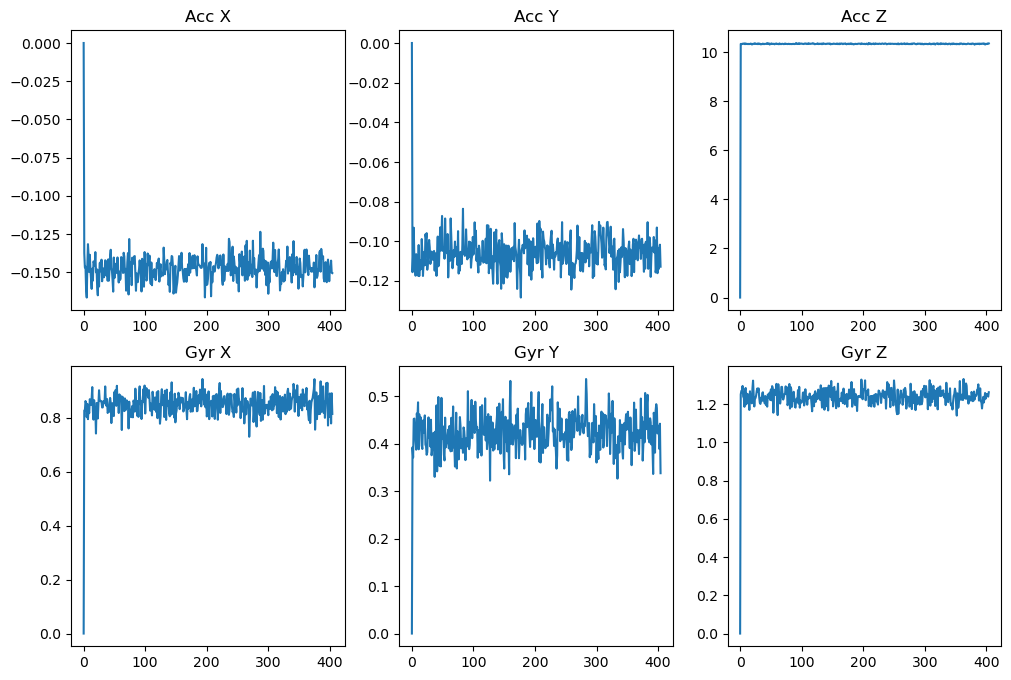

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.2)
axs[0, 0].plot(ax)
axs[0, 0].set_title('Acc X')
axs[0, 1].plot(ay)
axs[0, 1].set_title('Acc Y')
axs[0, 2].plot(az)
axs[0, 2].set_title('Acc Z')

axs[1, 0].plot(gx)
axs[1, 0].set_title('Gyr X')
axs[1, 1].plot(gy)
axs[1, 1].set_title('Gyr Y')
axs[1, 2].plot(gz)
axs[1, 2].set_title('Gyr Z')
plt.show()

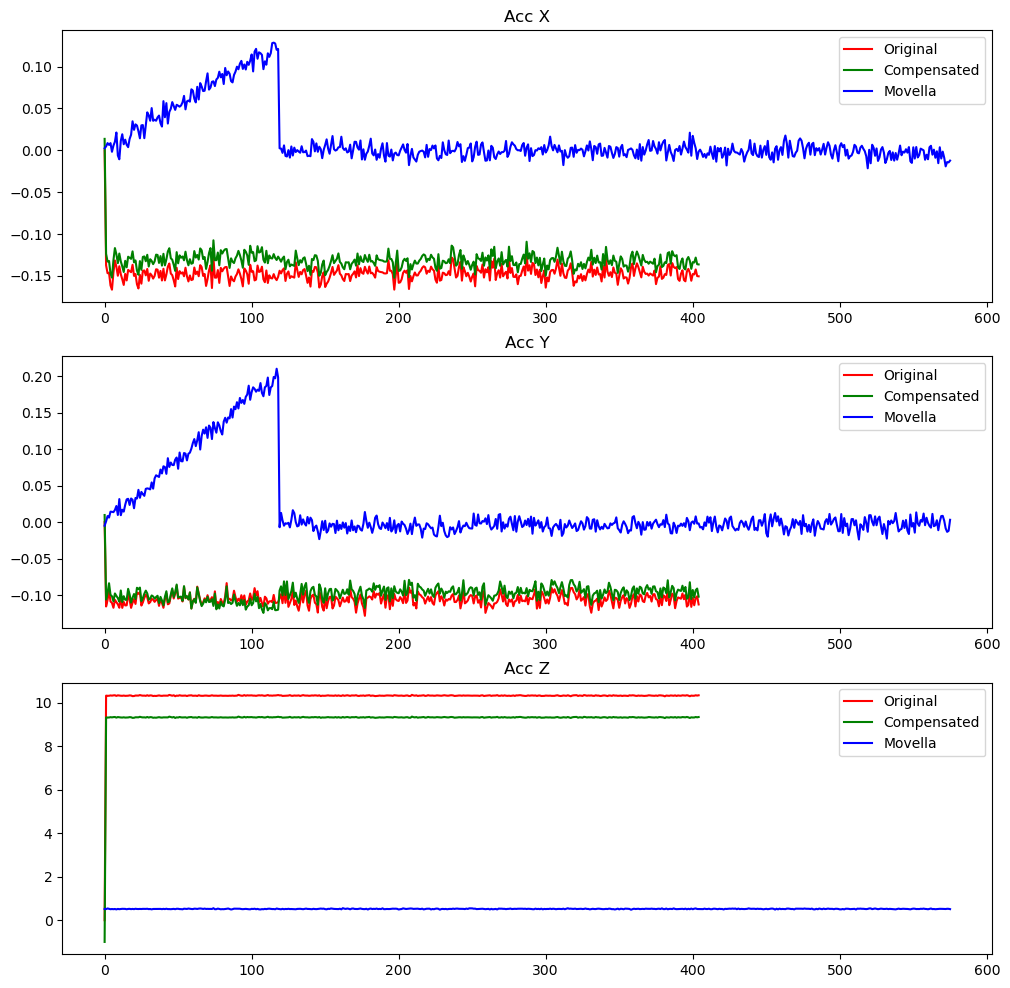

In [5]:
# compensate the accelerometer readings from gravity. 
# @param q the quaternion representing the orientation of a 9DOM MARG sensor array
# @param acc the readings coming from an accelerometer expressed in g
#
# @return a 3d vector representing dinamic acceleration expressed in g
def gravity_compensate(q, acc):
  g = [0.0, 0.0, 0.0]
  
  # get expected direction of gravity
  g[0] = 2 * (q[1] * q[3] - q[0] * q[2])
  g[1] = 2 * (q[0] * q[1] + q[2] * q[3])
  g[2] = q[0] * q[0] - q[1] * q[1] - q[2] * q[2] + q[3] * q[3]
  
  # compensate accelerometer readings with the expected direction of gravity
  return [acc[0] - g[0], acc[1] - g[1], acc[2] - g[2]]

acc_comp = gravity_compensate(q, acc)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.2)

# Plotting accelerometer data and compensated data
for i in range(3):
    axs[i].plot(acc[i], color='red', label='Original')
    axs[i].plot(acc_comp[i], color='green', label='Compensated')
    axs[i].plot(free_acc[i], color='blue', label='Movella')
    axs[i].set_title(f'Acc {["X", "Y", "Z"][i]}')
    axs[i].legend()

plt.show()

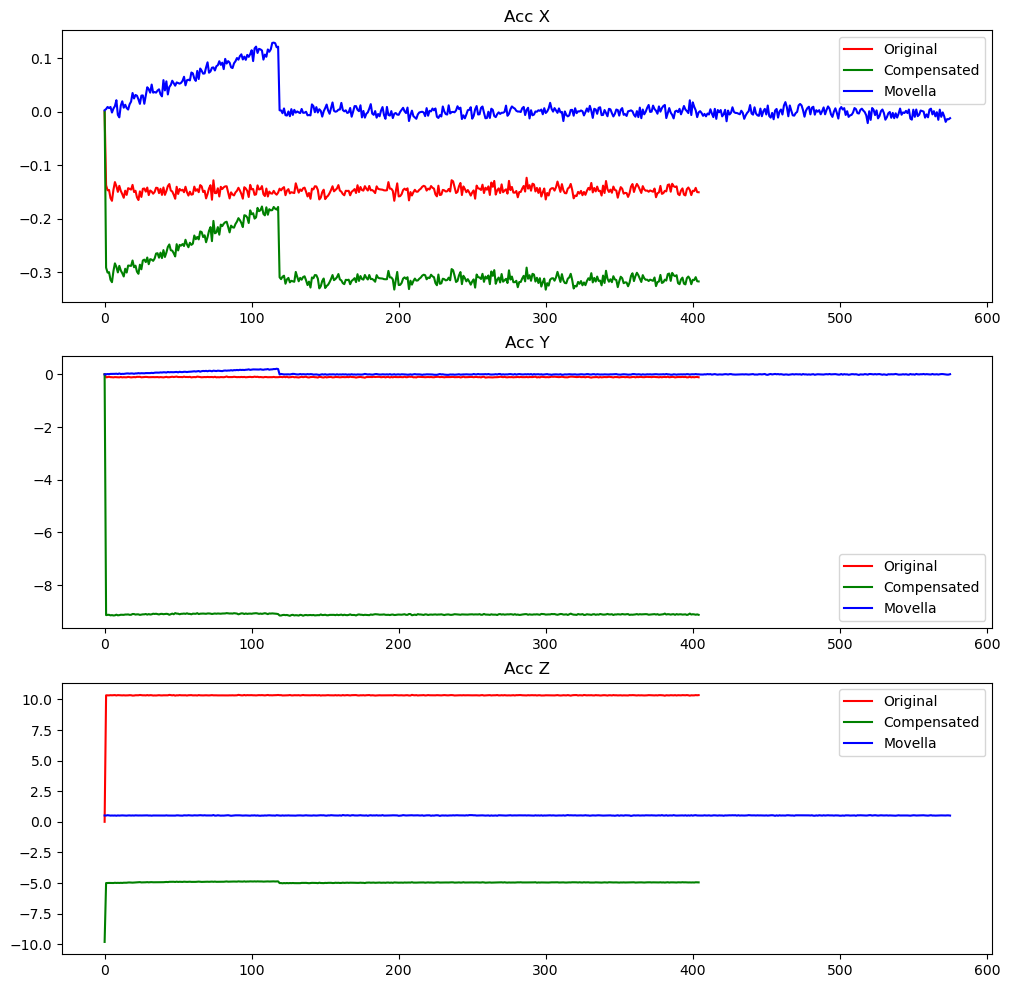

In [6]:
# Reshape quaternion data to have each quaternion as a row
# [qW, qX, qY, qZ], [qW1, qX1, qY1, qZ1], ...
num_quaternions = len(q[0])
quat = np.zeros((num_quaternions, 4))
for i in range(num_quaternions):
    quat[i] = [q[0][i], q[1][i], q[2][i], q[3][i]]
    
# Reshape acceleration data to have all axes acceleration in a row
# [ax, ay, az], [ax1, ay1, az1], ...
num_acc = len(acc[0])
acc_data = np.zeros((num_acc, 3))
for i in range(num_acc):
    acc_data[i] = [acc[0][i], acc[1][i], acc[2][i]]

# Gravitation as array [x, y, z]
g = np.array([0, 0, 9.81])

# Create global matrix using quaternions
acc_global = np.zeros((num_acc, 3))
for i in range(num_acc):
    # Quaternions to Rotation matrix
    r = Rotation.from_quat(quat).as_matrix()
    # Multiply R with measured acceleration
    acc_global[i] = np.dot(r[i], acc_data[i])

#Subtract gravitation from acceleration
acc_comp = acc_global - g

# Convert back to separate axes
acc_x = np.zeros(num_acc)
acc_y = np.zeros(num_acc)
acc_z = np.zeros(num_acc)
for i in range(num_acc):
    acc_x[i] = acc_comp[i][0]
    acc_y[i] = acc_comp[i][1]
    acc_z[i] = acc_comp[i][2]  
acc_comp = np.array([acc_x, acc_y, acc_z])

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.2)

# Plotting accelerometer data and compensated data
for i in range(3):
    axs[i].plot(acc[i], color='red', label='Original')
    axs[i].plot(acc_comp[i], color='green', label='Compensated')
    axs[i].plot(free_acc[i], color='blue', label='Movella')
    axs[i].set_title(f'Acc {["X", "Y", "Z"][i]}')
    axs[i].legend()

plt.show()